# OECD data

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#OECD-inflation-data" data-toc-modified-id="OECD-inflation-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>OECD inflation data</a></span><ul class="toc-item"><li><span><a href="#Simple-quarterly-comparison" data-toc-modified-id="Simple-quarterly-comparison-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Simple quarterly comparison</a></span></li><li><span><a href="#Monthly-where-available" data-toc-modified-id="Monthly-where-available-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Monthly where available</a></span></li><li><span><a href="#Annualised-and-quarterly-smoothed-(using-seasonally-adjusted-series)" data-toc-modified-id="Annualised-and-quarterly-smoothed-(using-seasonally-adjusted-series)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Annualised and quarterly smoothed (using seasonally adjusted series)</a></span></li></ul></li></ul></div>

## Python setup

In [1]:
# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandasdmx import Request
from scipy.signal import savgol_filter

# system imports
from pathlib import Path
from datetime import date

# local imports
from finalise_plot import finalise_plot

In [2]:
# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

# plotting stuff
plt.style.use('fivethirtyeight')

# multi-time-period charts
TODAY = pd.Timestamp('today')
RECENCY_PERIOD = 5 # years
RECENT = TODAY - pd.DateOffset(years=RECENCY_PERIOD)
MONTH_ADJ = 2 # months
RECENT = RECENT - pd.DateOffset(months=MONTH_ADJ)

# Other
SOURCE = "Source: OECD"

# Where to put the charts
CHART_DIR = "./charts/OECD"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)


## OECD inflation data

### Simple quarterly comparison

In [3]:
series = 'CPALTT01'
anglosphere = ['AUS', 'USA', 'CAN', 'NZL', 'GBR', 'IRL']
G7 = ['CAN', 'FRA', 'DEU', 'ITA', 'JPN', 'GBR', 'USA']
of_interest = ['AUS', 'USA', 'CAN', 'NZL', 'GBR', 'JPN']

def build_key(
    locations = anglosphere,
    subject=[series],
    measure = ['IXOB'],
    frequency = ['Q'],
    start = '1969',
):
    key = [locations, subject, measure, frequency]
    key_string = (
        f"{'.'.join(['+'.join(x) for x in key])}"
        f"/all?startTime={start}"
    )
    return key_string

In [4]:
# get the raw index data
def get_oecd_data(resource_id, key_string):
    oecd = Request('OECD')
    data = oecd.data(
        resource_id=resource_id,
        key=key_string,
    ).to_pandas()
    return data

In [5]:
# reframe the data from an index to growth
def reframe(raw, periods, freq=None, smooth=0, annualised=0):
    growth = (
        raw
        .unstack().T
        .pct_change(periods)
        .dropna(axis=0, how='all')
        .droplevel(axis=1, level=[1, 2, 3])
        * 100
    )
    if annualised:
        growth = growth * annualised
    if smooth:
        growth = growth.rolling(smooth).mean()
    if freq:
        growth.index = pd.PeriodIndex(growth.index, freq=freq)
    return growth

In [6]:
key_string = build_key()
cpi_q = get_oecd_data(resource_id='PRICES_CPI', key_string=key_string)
inflation_q = reframe(cpi_q, 4, 'Q')
inflation_q.tail()

LOCATION,AUS,CAN,GBR,IRL,NZL,USA
TIME_PERIOD,,,,,,
2021Q3,3.012121,4.062263,2.658112,2.917121,4.933597,5.335672
2021Q4,3.498242,4.726190,4.391583,5.308293,5.948983,6.689109
2022Q1,5.089035,5.831545,5.479452,5.782437,6.928877,7.966747
2022Q2,6.144817,7.546753,7.935077,7.952391,7.301279,8.635543
2022Q3,7.268105,7.152880,8.750000,8.662425,7.233233,8.329522


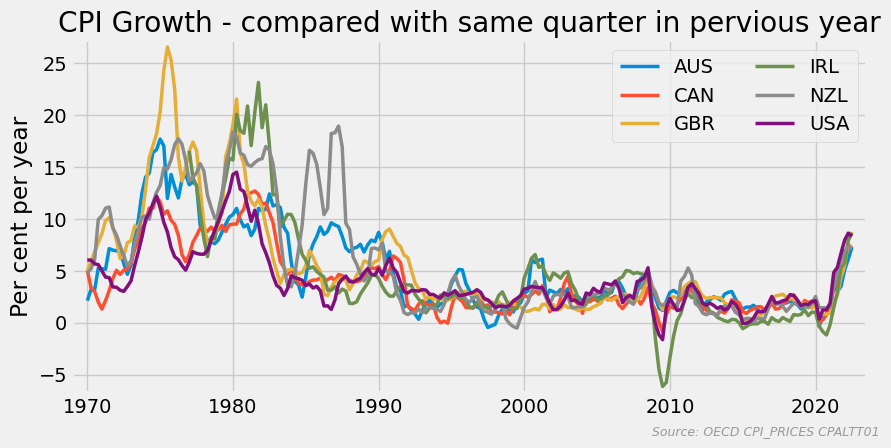

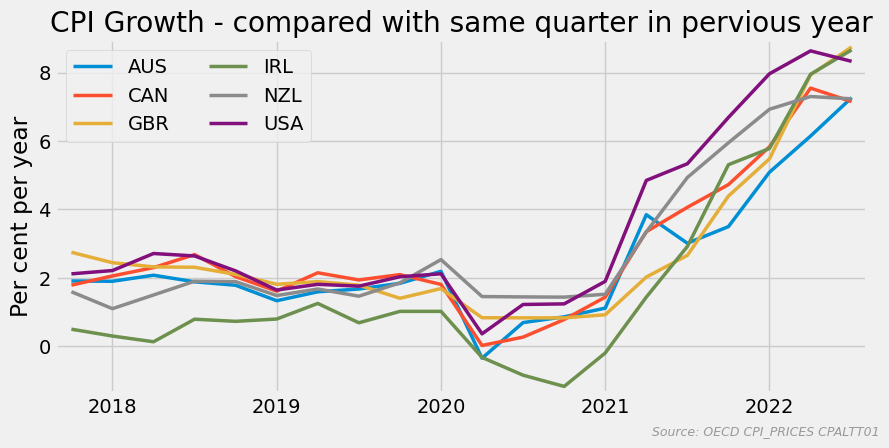

In [7]:
# plot the data
title = 'CPI Growth - compared with same quarter in pervious year'
for start in None, RECENT:
    data = (
        inflation_q if start is None 
        else inflation_q[inflation_q.index >= pd.Period(start, freq='Q')].copy()
    )
    ax = data.plot(lw=2.5)
    ax.legend(title=None, loc='best', ncol=2)
    tag = "" if start is None else '-recent'

    finalise_plot(
        ax, title, 
        'Per cent per year', 
        tag, CHART_DIR,
        rfooter=f'{SOURCE} CPI_PRICES {series}',
        show=True,
)

### Monthly where available

In [8]:
# merge monthly and quarterly data
def merge_mq(m, q):
    # copy data - non-destructive to original data
    mm = m.copy()
    qq = q.copy()
    
    # convert from PeriodIndex to DatetimeIndex
    for df in mm, qq:
        df.index = df.index.to_timestamp(how='end')
        df.index = [pd.Timestamp(x.date()) for x in df.index]
        
    # draw in quarterly where missing in monthly
    for col in qq.columns:
        if col not in mm.columns:
            mm[col] = qq[col]
        
    # interpolate and sort
    mm = mm.interpolate(method='time', limit_area='inside')
    mm = mm.sort_index(axis=1)
    
    return mm

In [9]:
# get monthly data 
key_string = build_key(frequency = ['M'])
cpi_m = get_oecd_data(resource_id='PRICES_CPI', key_string=key_string)
inflation_m = reframe(cpi_m, 12, 'M')

# merge monthly and quarterly
inflation_m2 = merge_mq(inflation_m, inflation_q)
inflation_m2.tail()

LOCATION,AUS,CAN,GBR,IRL,NZL,USA
2022-07-31,6.523317,7.589551,8.797127,9.125814,7.278350,8.524790
2022-08-31,6.901816,7.012645,8.652988,8.691578,7.255422,8.262722
2022-09-30,7.268105,6.857984,8.807829,8.174962,7.233233,8.201717
2022-10-31,NaN,6.879810,9.611993,9.159610,NaN,7.745437
2022-11-30,NaN,6.796065,9.377739,8.920164,NaN,7.110307


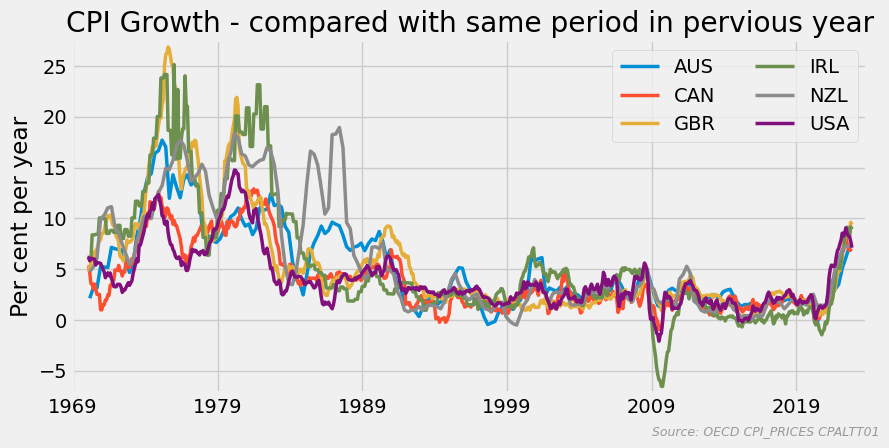

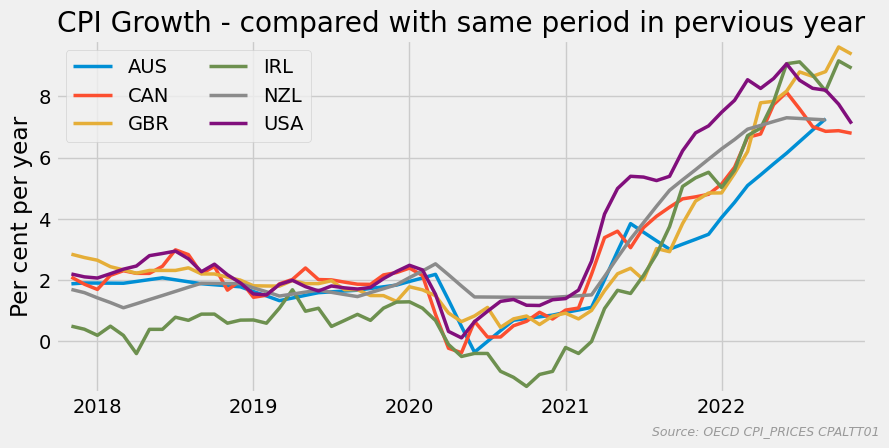

In [10]:
# plot 
title = 'CPI Growth - compared with same period in pervious year'
for start in None, RECENT:
    data = inflation_m2 if start is None else inflation_m2[inflation_m2.index >= start]
    ax = data.plot(lw=2.5)
    ax.legend(title=None, loc='best', ncol=2)
    tag = "" if start is None else '-recent'

    finalise_plot(
        ax, title, 
        'Per cent per year', 
        tag, CHART_DIR,
        rfooter=f'{SOURCE} CPI_PRICES {series}',
        show=True,
)

### Annualised and quarterly smoothed (using seasonally adjusted series)

In [11]:
# get monthly seasonally adjusted data - annualised and smoothed
key_string = build_key(frequency = ['M'], measure = ['IXOBSA'], )
cpi_m_sa = get_oecd_data(resource_id='PRICES_CPI', key_string=key_string)
inflation_m_sa = reframe(cpi_m_sa, 1, 'M', smooth=3, annualised=12)
inflation_m_sa.tail()

LOCATION,CAN,USA
TIME_PERIOD,,
2022-07,6.916010,9.107021
2022-08,2.903922,5.684427
2022-09,2.363453,1.939464
2022-10,4.190530,3.770091
2022-11,5.487181,3.682648


In [12]:
# get quarterly seasonally adjusted data - annualised
key_string = build_key(frequency = ['Q'], measure = ['IXOBSA'], )
cpi_q_sa = get_oecd_data(resource_id='PRICES_CPI', key_string=key_string)
inflation_q_sa = reframe(cpi_q_sa, 1, 'Q', annualised=4)
inflation_q_sa.tail()

LOCATION,AUS,CAN,USA
TIME_PERIOD,,,
2021Q3,3.370129,5.311656,6.552791
2021Q4,5.680777,5.616682,7.687949
2022Q1,8.237226,7.200718,8.899286
2022Q2,7.102552,10.881573,10.138992
2022Q3,7.295599,4.060973,5.568104


In [13]:
# merge monthly and quarterly
inflation_m_sa2 = merge_mq(inflation_m_sa, inflation_q_sa)
inflation_m_sa2.tail()

LOCATION,AUS,CAN,USA
2022-07-31,7.167600,6.916010,9.107021
2022-08-31,7.232649,2.903922,5.684427
2022-09-30,7.295599,2.363453,1.939464
2022-10-31,NaN,4.190530,3.770091
2022-11-30,NaN,5.487181,3.682648


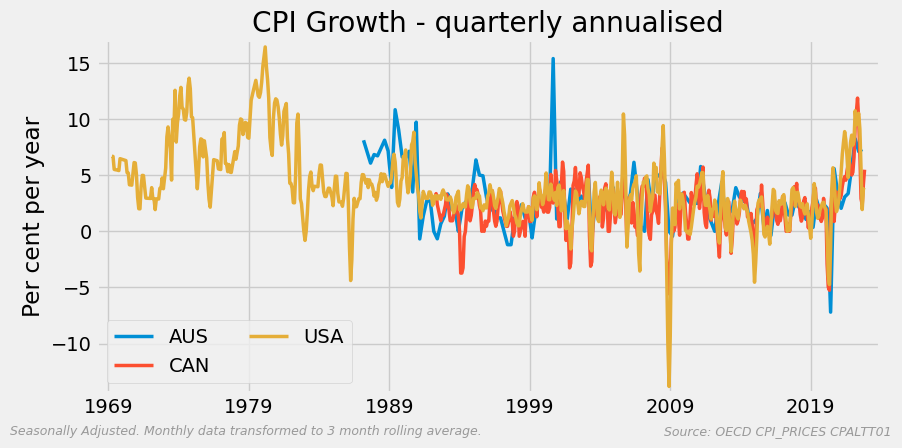

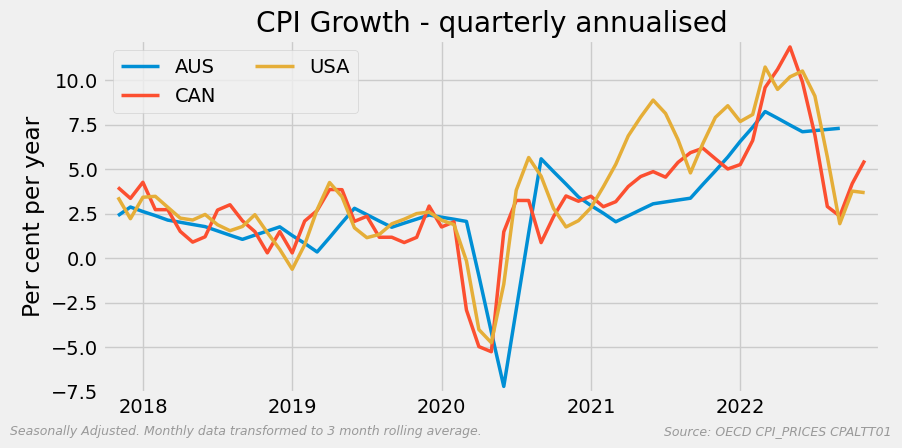

In [14]:
# plot 
title = 'CPI Growth - quarterly annualised'
for start in None, RECENT:
    data = inflation_m_sa2 if start is None else inflation_m_sa2[inflation_m_sa2.index >= start]
    ax = data.plot(lw=2.5)
    ax.legend(title=None, loc='best', ncol=2)
    tag = "" if start is None else '-recent'

    finalise_plot(
        ax, title, 
        'Per cent per year', 
        tag, CHART_DIR,
        rfooter=f'{SOURCE} CPI_PRICES {series}',
        lfooter='Seasonally Adjusted. Monthly data transformed to 3 month rolling average.',
        show=True,
)